In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from resnetgn import resnet50gn
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
EPOCHS = 25

## Data sets

In [5]:
train_ds = CIFAR10("/cifar", train=True, download=True,\
                   transform=T.Compose([
                        T.ToTensor(),
                        T.RandomResizedCrop(size=32),
                        T.RandomHorizontalFlip(),
                        T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ]))
test_ds = CIFAR10("/cifar", train=True, download=True,\
                  transform=T.Compose([
                        T.ToTensor(),
                        T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ]))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Utils

In [6]:
def test_accuracy(model, loader, device):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            i, l = data
            i, l = i.to(device), l.to(device)
            o = model(i)
            
            _, predicted = torch.max(o.data, 1)
            total += l.size(0)
            correct += (predicted == l).sum().item()

    return correct / total

In [7]:
def get_parameters_cnt(model):
    return sum(p.numel() for p in model.parameters())

# Batch normalization (BN)

In [9]:
get_parameters_cnt(torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device))

Using cache found in C:\Users\pietr/.cache\torch\hub\pytorch_vision_v0.10.0


25557032

## LR range

https://arxiv.org/pdf/1506.01186.pdf  par 3.3

In [ ]:
df_lr_range = pd.DataFrame(columns=["optim", "lr", "loss"])

### SGD

In [ ]:
loss_fn = nn.CrossEntropyLoss()

rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
optimizer = optim.SGD(rn50.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.01)
torch.manual_seed(20)
for _ in tqdm(range(15)):
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        optimizer.step()
        
        df_lr_range.loc[len(df_lr_range)] = ["sgd", scheduler.get_last_lr()[0], loss.item()]
        
        scheduler.step()

### Adam

In [ ]:
loss_fn = nn.CrossEntropyLoss()

rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
optimizer = optim.Adam(rn50.parameters(), lr=1e-6, weight_decay=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.01)
torch.manual_seed(20)
for _ in tqdm(range(15)):
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        optimizer.step()
        
        df_lr_range.loc[len(df_lr_range)] = ["adam", scheduler.get_last_lr()[0], loss.item()]
        
        scheduler.step()

### Comparison

In [ ]:
df_lr_range("lr_range_comparison.csv")

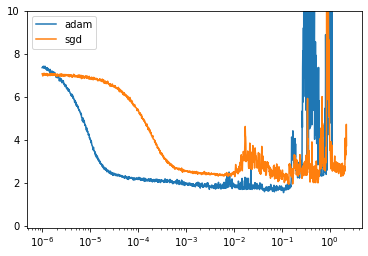

In [3]:
df_lr_range = pd.read_csv("lr_range_comparison.csv")
plt.plot(df_lr_range.loc[df_lr_range["optim"]=="adam", "lr"], df_lr_range.loc[df_lr_range["optim"]=="adam", "loss"], label="adam")
plt.plot(df_lr_range.loc[df_lr_range["optim"]=="sgd", "lr"], df_lr_range.loc[df_lr_range["optim"]=="sgd", "loss"], label="sgd")
plt.xscale("log")
plt.ylim([-0.1, 10])
plt.legend()

## Optimizer

In [ ]:
df_optim = pd.DataFrame(columns=["acc", "optim", "config"])

### Optimize Adam

In [ ]:
params = {
    "lr": [1e-2, 5e-3],
    "weight_decay": [1e-5, 1e-4, 1e-3]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.Adam(rn50.parameters(), **param)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=param["lr"], epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
    df_optim.loc[len(df_optim)] = [test_accuracy(rn50, test_dl, device), "adam", str(param)]

### Optimize SGD

In [ ]:
params = {
    "lr": [1e-2],
    "weight_decay": [1e-4, 1e-3, 1e-2, 0],
    "momentum": [0.9]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.SGD(rn50.parameters(), **param)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=param["lr"], epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
    df_optim.loc[len(df_optim)] = [test_accuracy(rn50, test_dl, device), "sgd", str(param)]

### Comparison

In [ ]:
df_optim.to_csv("optim_comparison.csv")

<AxesSubplot:xlabel='optim', ylabel='acc'>

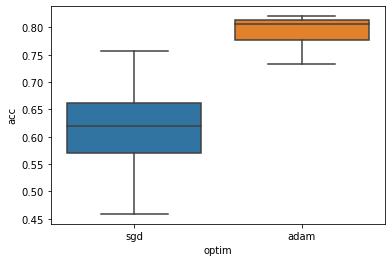

In [2]:
df_optim = pd.read_csv("optim_comparison.csv")
sns.boxplot(data=df_optim, x="optim", y="acc")

In [4]:
adam = df_optim.loc[df_optim["optim"]=="adam"]
adam = adam.sort_values(["acc", "optim", "config"], ascending=False)
sgd = df_optim.loc[df_optim["optim"]=="sgd"]
sgd = sgd.sort_values(["acc", "optim", "config"], ascending=False)

print(f"adam best: acc={adam.iloc[0]['acc']} config={adam.iloc[0]['config']}")
print(f"adam second best: acc={adam.iloc[1]['acc']} config={adam.iloc[1]['config']}")
print(f"sgd best: acc={sgd.iloc[0]['acc']} config={sgd.iloc[0]['config']}")
print(f"sgd second best: acc={sgd.iloc[1]['acc']} config={sgd.iloc[1]['config']}")

adam best: acc=0.82024 config={'lr': 0.005, 'weight_decay': 0.001}
adam second best: acc=0.81472 config={'lr': 0.005, 'weight_decay': 0.0001}
adam third best: acc=0.81038 config={'lr': 0.01, 'weight_decay': 0.0001}
sgd best: acc=0.75684 config={'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.01}
sgd second best: acc=0.63014 config={'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001}


## Gradient clipping

In [7]:
df_clip = pd.DataFrame(columns=["acc", "optim", "clip_value"])

### Adam best

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for cv in tqdm([1e-1, 1e-2]):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.Adam(rn50.parameters(), lr=5e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            nn.utils.clip_grad_value_(rn50.parameters(), cv)
            optimizer.step()
            scheduler.step()
            
    df_clip.loc[len(df_clip)] = [test_accuracy(rn50, test_dl, device), "adam", cv]

### SDG best

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for cv in tqdm([1e-1, 1e-2]):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.SGD(rn50.parameters(), lr=1e-2, weight_decay=1e-2, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            nn.utils.clip_grad_norm_(rn50.parameters(), cv)
            optimizer.step()
            scheduler.step()
            
    df_clip.loc[len(df_clip)] = [test_accuracy(rn50, test_dl, device), "sgd", cv]

### Comparison

In [16]:
df_clip.to_csv("clip_comparison.csv")

In [ ]:
df_clip = pd.read_csv("clip_comparison.csv")
plt.scatter([1e-1, 1e-2], df_clip.loc[df_clip["optim"]=="adam", "acc"], label="adam best")
plt.scatter([1e-1, 1e-2], df_clip.loc[df_clip["optim"]=="sgd", "acc"], label="sgd best")
plt.xscale("log")

## Upper bound

In [ ]:
df_bn = pd.DataFrame(columns=["acc", "loss"])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
optimizer = torch.optim.Adam(rn50.parameters(), lr=5e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=EPOCHS,
                                                steps_per_epoch=len(train_dl), pct_start=0.3,
                                                cycle_momentum=False, div_factor=5, final_div_factor=1e3)
torch.manual_seed(20)

for _ in range(50):
    total_loss = 0
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        nn.utils.clip_grad_norm_(rn50.parameters(), cv)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    
    df_bn.loc[len(df_bn)] = [test_accuracy(rn50, test_dl, device), total_loss/len(train_dl)]

In [ ]:
df_bn.to_csv("bn_acc_loss.csv")

In [ ]:
df_bf = pd.read_csv("bn_acc_loss.csv")
plt.plot(df_bn["acc"], label="accuracy")
plt.plot(df_bn["loss"], label="locc")
plt.legend()

# Group normalization (GN)

In [10]:
get_parameters_cnt(resnet50gn(num_groups=2))

25557032

## LR range

https://arxiv.org/pdf/1506.01186.pdf  par 3.3

In [11]:
df_lr_range = pd.DataFrame(columns=["optim", "lr", "loss"])

### Adam

In [12]:
loss_fn = nn.CrossEntropyLoss()

rn50 = resnet50gn(num_groups=2).to(device)
optimizer = optim.Adam(rn50.parameters(), lr=1e-6, weight_decay=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.01)
torch.manual_seed(20)
for _ in tqdm(range(15)):
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        optimizer.step()
        
        df_lr_range.loc[len(df_lr_range)] = ["adam", scheduler.get_last_lr()[0], loss.item()]
        
        scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [15:09<00:00, 60.63s/it]


### SGD

In [ ]:
loss_fn = nn.CrossEntropyLoss()

rn50 = resnet50gn(num_groups=2).to(device)
optimizer = optim.SGD(rn50.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.01)
torch.manual_seed(20)
for _ in tqdm(range(15)):
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        optimizer.step()
        
        df_lr_range.loc[len(df_lr_range)] = ["sgd", scheduler.get_last_lr()[0], loss.item()]
        
        scheduler.step()

 67%|██████████████████████████████████████████████████████▋                           | 10/15 [09:40<04:51, 58.33s/it]

### Comparison

In [ ]:
df_lr_range("gn_lr_range_comparison.csv")

In [ ]:
df_lr_range = pd.read_csv("gn_lr_range_comparison.csv")
plt.plot(df_lr_range.loc[df_lr_range["optim"]=="adam", "lr"], df_lr_range.loc[df_lr_range["optim"]=="adam", "loss"], label="adam")
plt.plot(df_lr_range.loc[df_lr_range["optim"]=="sgd", "lr"], df_lr_range.loc[df_lr_range["optim"]=="sgd", "loss"], label="sgd")
plt.xscale("log")
plt.ylim([-0.1, 10])
plt.legend()

## Optimizer

In [ ]:
df_optim = pd.DataFrame(columns=["acc", "optim", "config"])

### Optimize Adam

In [ ]:
params = {
    "lr": [1e-2, 5e-3],
    "weight_decay": [1e-5, 1e-4, 1e-3]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = resnet50gn(num_groups=2).to(device)
    optimizer = torch.optim.Adam(rn50.parameters(), **param)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=param["lr"], epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
    df_optim.loc[len(df_optim)] = [test_accuracy(rn50, test_dl, device), "adam", str(param)]

### Optimize SGD

In [ ]:
params = {
    "lr": [1e-2],
    "weight_decay": [1e-4, 1e-3, 1e-2, 0],
    "momentum": [0.9]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.SGD(rn50.parameters(), **param)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=param["lr"], epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
    df_optim.loc[len(df_optim)] = [test_accuracy(rn50, test_dl, device), "sgd", str(param)]

### Comparison

In [ ]:
df_optim.to_csv("gn_optim_comparison.csv")

In [ ]:
df_optim = pd.read_csv("gn_optim_comparison.csv")
sns.boxplot(data=df_optim, x="optim", y="acc")

In [ ]:
adam = df_optim.loc[df_optim["optim"]=="adam"]
adam = adam.sort_values(["acc", "optim", "config"], ascending=False)
sgd = df_optim.loc[df_optim["optim"]=="sgd"]
sgd = sgd.sort_values(["acc", "optim", "config"], ascending=False)

print(f"adam best: acc={adam.iloc[0]['acc']} config={adam.iloc[0]['config']}")
print(f"adam second best: acc={adam.iloc[1]['acc']} config={adam.iloc[1]['config']}")
print(f"sgd best: acc={sgd.iloc[0]['acc']} config={sgd.iloc[0]['config']}")
print(f"sgd second best: acc={sgd.iloc[1]['acc']} config={sgd.iloc[1]['config']}")

## Gradient clipping

In [ ]:
df_clip = pd.DataFrame(columns=["acc", "optim", "clip_value"])

### Adam best

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for cv in tqdm([1e-1, 1e-2]):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    # TODO: set lr, weight_decay, max_lr(=lr) according to results
    optimizer = torch.optim.Adam(rn50.parameters(), lr=?, weight_decay=?)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=?, epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            nn.utils.clip_grad_value_(rn50.parameters(), cv)
            optimizer.step()
            scheduler.step()
            
    df_clip.loc[len(df_clip)] = [test_accuracy(rn50, test_dl, device), "adam", cv]

### SGD best

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for cv in tqdm([1e-1, 1e-2]):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    # TODO: set lr, weight_decay, momentum, max_lr(=lr) according to results
    optimizer = torch.optim.SGD(rn50.parameters(), lr=?, weight_decay=?, momentum=?)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=?, epochs=EPOCHS,
                                                    steps_per_epoch=len(train_dl), pct_start=0.3,
                                                    cycle_momentum=False, div_factor=5, final_div_factor=1e3)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            i, l = data
            i, l = i.to(device), l.to(device)
            optimizer.zero_grad()
            o = rn50(i)
            loss = loss_fn(o, l)
            loss.backward()
            nn.utils.clip_grad_norm_(rn50.parameters(), cv)
            optimizer.step()
            scheduler.step()
            
    df_clip.loc[len(df_clip)] = [test_accuracy(rn50, test_dl, device), "sgd", cv]

### Comparison

In [ ]:
df_clip.to_csv("gn_clip_comparison.csv")

In [ ]:
df_clip = pd.read_csv("gn_clip_comparison.csv")
plt.scatter([1e-1, 1e-2], df_clip.loc[df_clip["optim"]=="adam1", "acc"], label="adam")
plt.scatter([1e-1, 1e-2], df_clip.loc[df_clip["optim"]=="sgd", "acc"], label="sgd")
plt.xscale("log")

## Upper bound

In [ ]:
df_gn = pd.DataFrame(columns=["acc", "loss"])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

rn50 = resnet50gn(num_groups=2).to(device)
optimizer = torch.optim.Adam(rn50.parameters(), lr=5e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=EPOCHS,
                                                steps_per_epoch=len(train_dl), pct_start=0.3,
                                                cycle_momentum=False, div_factor=5, final_div_factor=1e3)
torch.manual_seed(20)

for _ in range(50):
    total_loss = 0
    for data in train_dl:
        i, l = data
        i, l = i.to(device), l.to(device)
        optimizer.zero_grad()
        o = rn50(i)
        loss = loss_fn(o, l)
        loss.backward()
        nn.utils.clip_grad_norm_(rn50.parameters(), cv)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    
    df_gn.loc[len(df_gn)] = [test_accuracy(rn50, test_dl, device), total_loss/len(train_dl)]

In [ ]:
df_bn.to_csv("gn_acc_loss.csv")

In [ ]:
df_bf = pd.read_csv("gn_acc_loss.csv")
plt.plot(df_bn["acc"], label="accuracy")
plt.plot(df_bn["loss"], label="locc")
plt.legend()